In [1]:
import random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from BostonMech import BostonMechanism
from DA import DeferredAcceptance
import utils as utils


%load_ext autoreload
%autoreload 2

## Function Definition 

In [2]:
###############################################################################
# functions for plotting
###############################################################################


def dist_by_choice(DA_results, BM_results, CP_results, savename):
    # DA
    _, axs = plt.subplots(1, 2, figsize=(12, 3))
    res_DA_soph = utils.plot_frac_choice(
        DA_results,
        "sophisticated",
        n_iter,
        [
            axs[0],
            "Deferred Acceptance (Sophisticated)",
            "fraction of students",
            "ranking achieved",
            "darkblue",
            (0, 0.25),
        ],
    )
    res_DA_sinc = utils.plot_frac_choice(
        DA_results,
        "sincere",
        n_iter,
        [
            axs[1],
            "Deferred Acceptance (Sincere)",
            "fraction of students",
            "ranking achieved",
            "darkblue",
            (0, 0.25),
        ],
    )
    plt.savefig(f"../figures/DA_{savename}.png", bbox_inches="tight")

    # BM
    _, axs = plt.subplots(1, 2, figsize=(12, 3))
    res_BM_soph = utils.plot_frac_choice(
        BM_results,
        "sophisticated",
        n_iter,
        [
            axs[0],
            "Boston Mechanism (Sophisticated)",
            "fraction of students",
            "ranking achieved",
            "maroon",
            (0, 0.25),
        ],
    )
    res_BM_sinc = utils.plot_frac_choice(
        BM_results,
        "sincere",
        n_iter,
        [
            axs[1],
            "Boston Mechanism (Sincere)",
            "fraction of students",
            "ranking achieved",
            "maroon",
            (0, 0.25),
        ],
    )
    plt.savefig(f"../figures/BM_{savename}.png", bbox_inches="tight")

    # CP
    _, axs = plt.subplots(1, 2, figsize=(12, 3))
    res_CP_soph = utils.plot_frac_choice(
        CP_results,
        "sophisticated",
        n_iter,
        [
            axs[0],
            "Chinese Parallel Mechanism (Sophisticated)",
            "fraction of students",
            "ranking achieved",
            "darkorange",
            (0, 0.25),
        ],
    )
    res_CP_sinc = utils.plot_frac_choice(
        CP_results,
        "sincere",
        n_iter,
        [
            axs[1],
            "Chinese Parallel Mechanism (Sincere)",
            "fraction of students",
            "ranking achieved",
            "darkorange",
            (0, 0.25),
        ],
    )
    plt.savefig(f"../figures/CP_{savename}.png", bbox_inches="tight")

    print(
        "BM sophisticated:", [(i + 1, round(n, 2)) for i, n in enumerate(res_BM_soph)]
    )
    print("BM sincere:", [(i + 1, round(n, 2)) for i, n in enumerate(res_BM_sinc)])

    print(
        "CP sophisticated:", [(i + 1, round(n, 2)) for i, n in enumerate(res_CP_soph)]
    )
    print("CP sincere:", [(i + 1, round(n, 2)) for i, n in enumerate(res_CP_sinc)])


def bar_plot_ave_ranking(DA_results, BM_results, CP_results, savename):
    _, axs = plt.subplots(1, 2, figsize=(12, 3))
    utils.plot_results(
        [DA_results, BM_results, CP_results],
        n_iter,
        "ranking_ave",
        [
            "Average Ranking Achieved by Students",
            "average ranking",
            ["sophisticated", "sincere", "sophisticated", "sincere"],
            False,
            axs[0],
        ],
        CP=False,
    )
    utils.plot_results(
        [DA_results, BM_results, CP_results],
        n_iter,
        "ranking_std",
        [
            "Standard Deviate of Ranking Achieved by Students",
            "standard deviation of rankings",
            ["sophisticated", "sincere", "sophisticated", "sincere"],
            True,
            axs[1],
        ],
        CP=False,
    )

    plt.savefig(f"../figures/DABM_{savename}.png", bbox_inches="tight")

    _, axs = plt.subplots(1, 2, figsize=(12, 3))
    utils.plot_results(
        [DA_results, BM_results, CP_results],
        n_iter,
        "ranking_ave",
        [
            "Average Ranking Achieved by Students",
            "average ranking",
            ["soph", "sinc", "soph", "sinc", "soph", "sinc"],
            False,
            axs[0],
        ],
        CP=True,
    )
    utils.plot_results(
        [DA_results, BM_results, CP_results],
        n_iter,
        "ranking_std",
        [
            "Standard Deviate of Ranking Achieved by Students",
            "standard deviation of rankings",
            ["soph", "sinc", "soph", "sinc", "soph", "sinc"],
            True,
            axs[1],
        ],
        CP=True,
    )

    plt.savefig(f"../figures/DABMCP_{savename}.png", bbox_inches="tight")


def dist_rank_change(rank_improvs_DA, rank_improvs_CP, soph_idx, savename):
    _, axs = plt.subplots(1, 1, figsize=(6, 3))

    pooled_rank = rank_improvs_DA[:, soph_idx].flatten()
    utils.plot_hist(
        pooled_rank,
        [
            axs,
            "From Bostom Mechanism to Deferred Acceptance",
            "density",
            "change in ranking",
            "sophisticated",
            "maroon",
            np.arange(-15.5, 16.5, 1),
        ],
    )
    pooled_rank = np.array(
        [
            rank_improvs_DA[:, idx]
            for idx in range(rank_improvs_DA.shape[1])
            if idx not in soph_idx
        ]
    ).flatten()
    utils.plot_hist(
        pooled_rank,
        [
            axs,
            "From Bostom Mechanism to Deferred Acceptance",
            "density",
            "change in ranking",
            "sincere",
            "darkblue",
            np.arange(-15.5, 16.5, 1),
        ],
    )
    plt.savefig(f"../figures/BM2DA_{savename}.png", bbox_inches="tight")

    _, axs = plt.subplots(1, 1, figsize=(6, 3))

    pooled_rank = rank_improvs_CP[:, soph_idx].flatten()
    utils.plot_hist(
        pooled_rank,
        [
            axs,
            "From Bostom Mechanism to Chinese Parallel",
            "density",
            "change in ranking",
            "sophisticated",
            "maroon",
            np.arange(-15.5, 16.5, 1),
        ],
    )
    pooled_rank = np.array(
        [
            rank_improvs_CP[:, idx]
            for idx in range(rank_improvs_CP.shape[1])
            if idx not in soph_idx
        ]
    ).flatten()
    utils.plot_hist(
        pooled_rank,
        [
            axs,
            "From Bostom Mechanism to Chinese Parallel",
            "density",
            "change in ranking",
            "sincere",
            "darkblue",
            np.arange(-15.5, 16.5, 1),
        ],
    )
    plt.savefig(f"../figures/BM2CP_{savename}.png", bbox_inches="tight")


###############################################################################
# Function to compute some statistics
###############################################################################
def frac_ppl_improve(rank_improvs_DA, rank_improvs_CP, soph_idx):
    rank_improvs_sinc = np.array(
        [
            rank_improvs_DA[:, idx]
            for idx in range(rank_improvs_DA.shape[1])
            if idx not in soph_idx
        ]
    ).T  # (ntrials, n_sinc)
    rank_improvs_soph = np.array(rank_improvs_DA[:, soph_idx])  # (ntrials, n_soph)

    rank_improv_frac_all = np.mean(np.mean(rank_improvs_DA < 0, axis=1))  # (ntrials,)
    rank_improv_frac_soph = np.mean(
        np.mean(rank_improvs_soph < 0, axis=1)
    )  # (ntrials,)
    rank_improv_frac_sinc = np.mean(
        np.mean(rank_improvs_sinc < 0, axis=1)
    )  # (ntrials,)

    print("Fraction of people who improved their ranking in DA:")
    print("All:", rank_improv_frac_all)
    print("Sophisticated:", rank_improv_frac_soph)
    print("Sincere:", rank_improv_frac_sinc)
    print("------------------------------------------------------")

    rank_improvs_sinc = np.array(
        [
            rank_improvs_CP[:, idx]
            for idx in range(rank_improvs_CP.shape[1])
            if idx not in soph_idx
        ]
    ).T  # (ntrials, n_sinc)
    rank_improvs_soph = np.array(rank_improvs_CP[:, soph_idx])  # (ntrials, n_soph)

    rank_improv_frac_all = np.mean(np.mean(rank_improvs_CP < 0, axis=1))  # (ntrials,)
    rank_improv_frac_soph = np.mean(
        np.mean(rank_improvs_soph < 0, axis=1)
    )  # (ntrials,)
    rank_improv_frac_sinc = np.mean(
        np.mean(rank_improvs_sinc < 0, axis=1)
    )  # (ntrials,)

    print("Fraction of people who improved their ranking in CP:")
    print("All:", rank_improv_frac_all)
    print("Sophisticated:", rank_improv_frac_soph)
    print("Sincere:", rank_improv_frac_sinc)
    print("------------------------------------------------------")


def ave_rank_change(rank_improvs_DA, rank_improvs_CP):
    n_ranking_dec = rank_improvs_DA.mean()
    print(
        f"On average, each student is worse off by {n_ranking_dec:.3f} rank switching to DA."
    )
    print("------------------------------------------------------")

    n_ranking_dec = rank_improvs_CP.mean()
    print(
        f"On average, each student is worse off by {n_ranking_dec:.3f} rank switching to CP."
    )
    print("------------------------------------------------------")


def count_blocking_pairs(DA_results, BM_results, CP_results):
    ave_nblocks = np.mean(n_blocks_DA)
    print(f"{ave_nblocks} blocking pairs in DA.")

    ave_nblocks = np.mean(n_blocks_BM)
    print(f"{ave_nblocks} blocking pairs in BM.")

    ave_nblocks = np.mean(n_blocks_CP)
    print(f"{ave_nblocks} blocking pairs in CP.")



## Fraction of Sophisticated Students = 0.2

In [3]:
perc_soph = 0.2
n_iter = 50
DA_results, BM_results, CP_results, rank_improvs_DA, rank_improvs_CP, n_blocks_DA, n_blocks_BM, n_blocks_CP, soph_idx = utils.simulation_wrapper(perc_soph, n_iter)

100%|██████████| 50/50 [01:30<00:00,  1.82s/it]


BM sophisticated: [(1, 0.22), (2, 0.11), (3, 0.11), (4, 0.1), (5, 0.09), (6, 0.02), (7, 0.05), (8, 0.08), (9, 0.1), (10, 0.06), (11, 0.02), (12, 0.01), (13, 0.01), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]
BM sincere: [(1, 0.22), (2, 0.03), (3, 0.06), (4, 0.11), (5, 0.07), (6, 0.03), (7, 0.06), (8, 0.1), (9, 0.14), (10, 0.09), (11, 0.02), (12, 0.01), (13, 0.01), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]
CP sophisticated: [(1, 0.1), (2, 0.11), (3, 0.13), (4, 0.08), (5, 0.09), (6, 0.1), (7, 0.03), (8, 0.05), (9, 0.08), (10, 0.1), (11, 0.06), (12, 0.03), (13, 0.02), (14, 0.01), (15, 0.01), (16, 0.0), (17, 0.0)]
CP sincere: [(1, 0.1), (2, 0.11), (3, 0.13), (4, 0.02), (5, 0.05), (6, 0.11), (7, 0.03), (8, 0.06), (9, 0.1), (10, 0.12), (11, 0.07), (12, 0.04), (13, 0.02), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]


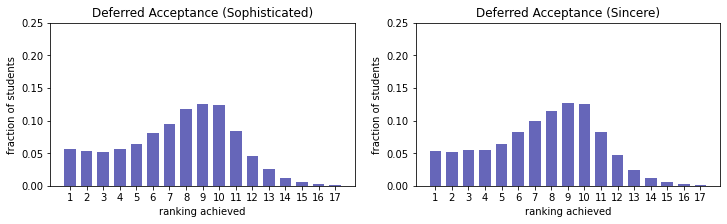

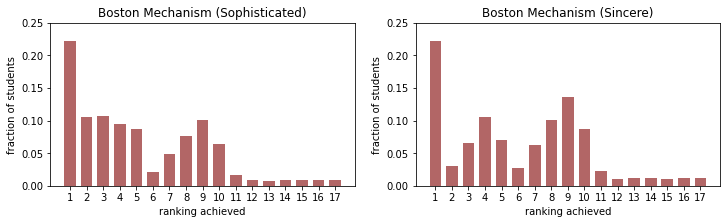

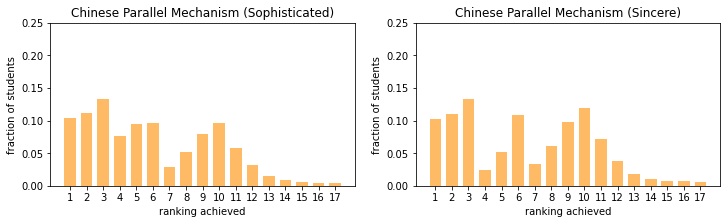

In [4]:
dist_by_choice(DA_results, BM_results, CP_results, 'frac_choice_p2')

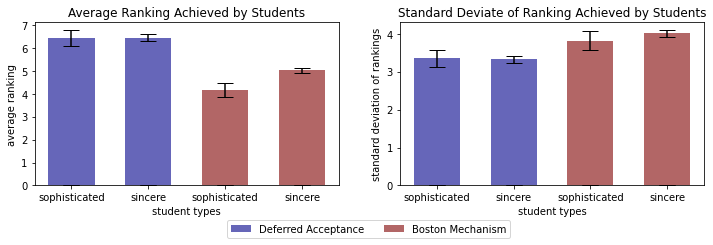

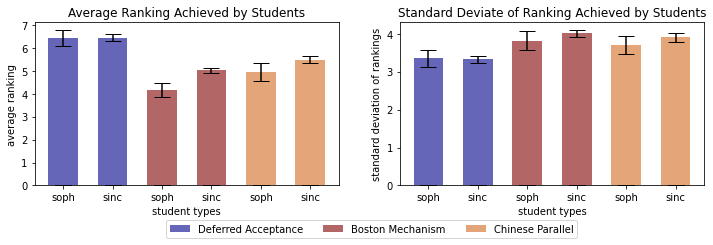

In [5]:
bar_plot_ave_ranking(DA_results, BM_results, CP_results, 'rank_ave_std_p2')

(min, max): (-15.0, 16.0)
(min, max): (-15.0, 16.0)
(min, max): (-15.0, 15.0)
(min, max): (-15.0, 16.0)


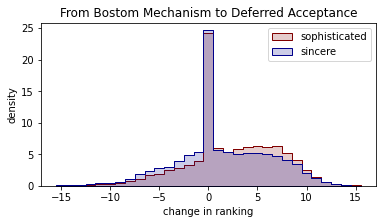

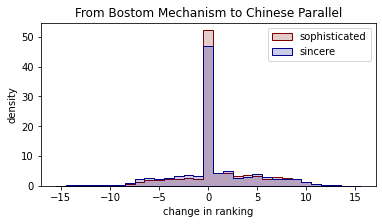

In [6]:
dist_rank_change(rank_improvs_DA, rank_improvs_CP, soph_idx, 'rank_change_hist_p2')

In [7]:
frac_ppl_improve(rank_improvs_DA, rank_improvs_CP, soph_idx)
ave_rank_change(rank_improvs_DA, rank_improvs_CP)
count_blocking_pairs(DA_results, BM_results, CP_results)

Fraction of people who improved their ranking in DA:
All: 0.2575371549893843
Sophisticated: 0.19430851063829788
Sincere: 0.27330238726790457
------------------------------------------------------
Fraction of people who improved their ranking in CP:
All: 0.21544585987261144
Sophisticated: 0.16792553191489362
Sincere: 0.22729442970822283
------------------------------------------------------
On average, each student is worse off by 1.583 rank switching to DA.
------------------------------------------------------
On average, each student is worse off by 0.521 rank switching to CP.
------------------------------------------------------
0.0 blocking pairs in DA.
3991.38 blocking pairs in BM.
3478.5 blocking pairs in CP.


## Fraction of Sophisticated Students = 0.8

In [8]:
perc_soph = 0.8
n_iter = 50
DA_results, BM_results, CP_results, rank_improvs_DA, rank_improvs_CP, n_blocks_DA, n_blocks_BM, n_blocks_CP, soph_idx = utils.simulation_wrapper(perc_soph, n_iter)

100%|██████████| 50/50 [01:38<00:00,  1.96s/it]


BM sophisticated: [(1, 0.17), (2, 0.09), (3, 0.1), (4, 0.09), (5, 0.09), (6, 0.03), (7, 0.06), (8, 0.09), (9, 0.12), (10, 0.08), (11, 0.02), (12, 0.01), (13, 0.01), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]
BM sincere: [(1, 0.17), (2, 0.03), (3, 0.06), (4, 0.1), (5, 0.05), (6, 0.03), (7, 0.07), (8, 0.12), (9, 0.16), (10, 0.1), (11, 0.03), (12, 0.01), (13, 0.02), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]
CP sophisticated: [(1, 0.1), (2, 0.11), (3, 0.13), (4, 0.07), (5, 0.09), (6, 0.08), (7, 0.03), (8, 0.06), (9, 0.09), (10, 0.11), (11, 0.07), (12, 0.04), (13, 0.02), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.0)]
CP sincere: [(1, 0.1), (2, 0.11), (3, 0.13), (4, 0.02), (5, 0.04), (6, 0.09), (7, 0.04), (8, 0.07), (9, 0.11), (10, 0.13), (11, 0.08), (12, 0.04), (13, 0.02), (14, 0.01), (15, 0.01), (16, 0.01), (17, 0.01)]


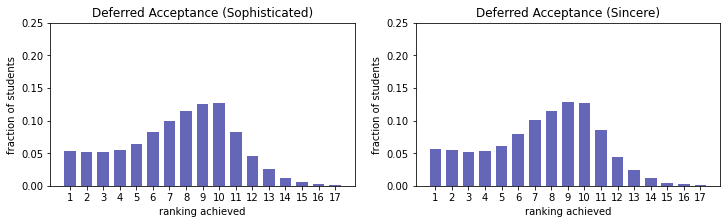

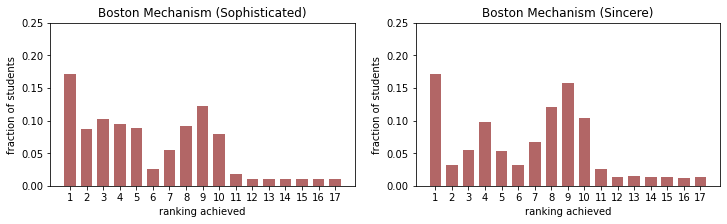

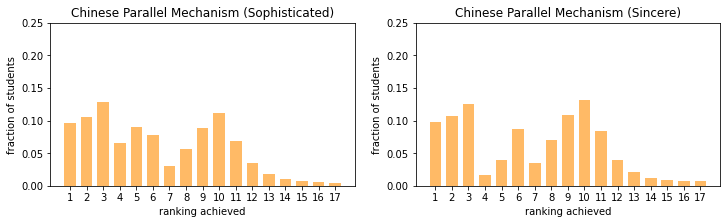

In [9]:
dist_by_choice(DA_results, BM_results, CP_results, 'frac_choice_p8')

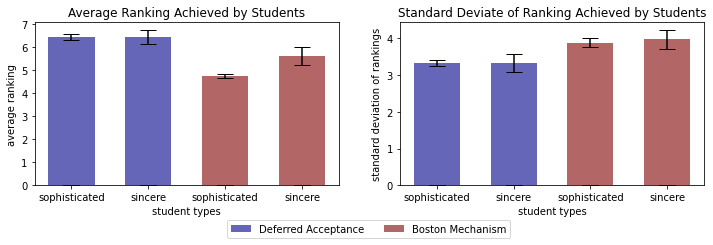

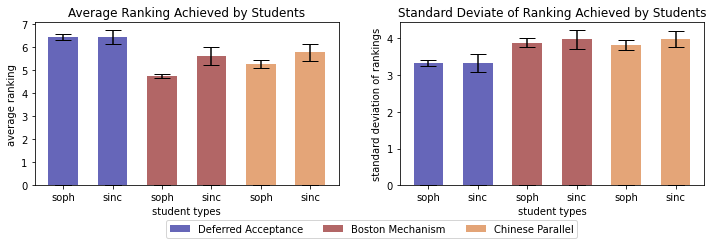

In [10]:
bar_plot_ave_ranking(DA_results, BM_results, CP_results, 'rank_ave_std_p8')

(min, max): (-15.0, 16.0)
(min, max): (-15.0, 16.0)
(min, max): (-15.0, 16.0)
(min, max): (-15.0, 15.0)


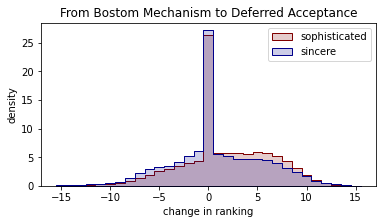

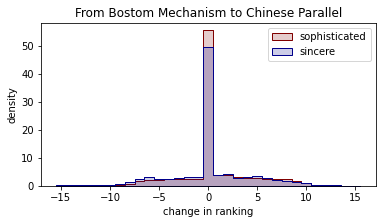

In [11]:
dist_rank_change(rank_improvs_DA, rank_improvs_CP, soph_idx, 'rank_change_hist_p8')

In [12]:
frac_ppl_improve(rank_improvs_DA, rank_improvs_CP, soph_idx)
ave_rank_change(rank_improvs_DA, rank_improvs_CP)
count_blocking_pairs(DA_results, BM_results, CP_results)

Fraction of people who improved their ranking in DA:
All: 0.24544585987261144
Sophisticated: 0.22966157929661576
Sincere: 0.30854111405835544
------------------------------------------------------
Fraction of people who improved their ranking in CP:
All: 0.18708067940552017
Sophisticated: 0.17547445255474448
Sincere: 0.23347480106100793
------------------------------------------------------
On average, each student is worse off by 1.506 rank switching to DA.
------------------------------------------------------
On average, each student is worse off by 0.444 rank switching to CP.
------------------------------------------------------
0.0 blocking pairs in DA.
3690.1 blocking pairs in BM.
3359.08 blocking pairs in CP.
